# Bitcoin prediction model
Here we build a Machine Learning model for predicting future Bitcoin values. 

## Get the data
First off we need to get the historical bitcoin data. Luckily we have found and downloaded this data in CSV format and we keep this in our data folder. So we just need to load that file.
For this purpose we will use Pandas, which give us a Pandas.DataFrame to work with. 

In [57]:
# Imports 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler

plt.style.use('seaborn-darkgrid')

In [58]:
# https://www.CryptoDataDownload.com
# Load the data 
df = pd.read_csv('../data/Binance_BTCUSDT_d.csv', sep=",")
df.shape

(1364, 10)

We have now loaded the data into a pandas dataframe. The shape looks good and as expected.

## Selecting meaningful data
Our context is to predict futere values, so we will use the columns representing existing values. 
In our dataset this is the columns date, low and high (low and high are highest and lowest value within the 24 span of the data row)

In [59]:
# Extract relevant data from the dataframe
df = df[['date', 'low', 'high']]
df

,date,low,high
0,2021-05-10 00:00:00,58240.83,58377.67
1,2021-05-09 00:00:00,56235.66,59300.00
2,2021-05-08 00:00:00,56900.00,59500.00
3,2021-05-07 00:00:00,55241.63,58650.00
4,2021-05-06 00:00:00,55200.00,58360.00
...,...,...,...
1359,2017-08-21,3911.79,4119.62
1360,2017-08-20,4032.62,4211.08
1361,2017-08-19,3850.00,4184.69
1362,2017-08-18,3938.77,4371.52


In [60]:
# Get an overview of the selected data 
df.describe()

,low,high
count,1364.000000,1364.000000
mean,11939.905916,12757.801921
std,12213.891371,13106.733936
min,2817.000000,3276.500000
25%,6361.482500,6629.400000
50%,8278.500000,8800.475000
75%,10608.770000,11355.275000
max,62020.000000,64854.000000


## Cleaning the data
We will now found out if the data should be cleaned and clean it if nessesary.

In [61]:
# Checking for nan/null values in our dataset
nan_date, nan_low, nan_high = df['date'].isna().sum(),df['low'].isna().sum(),df['high'].isna().sum()

nan_date, nan_low, nan_high

(0, 0, 0)

Our data does not include nan/null values. But we notised that the dates does not follow the same struckture. This can be seen by comparing head and tail: 

In [62]:
df.head(), df.tail()

(                  date       low      high
 0  2021-05-10 00:00:00  58240.83  58377.67
 1  2021-05-09 00:00:00  56235.66  59300.00
 2  2021-05-08 00:00:00  56900.00  59500.00
 3  2021-05-07 00:00:00  55241.63  58650.00
 4  2021-05-06 00:00:00  55200.00  58360.00,
             date      low     high
 1359  2017-08-21  3911.79  4119.62
 1360  2017-08-20  4032.62  4211.08
 1361  2017-08-19  3850.00  4184.69
 1362  2017-08-18  3938.77  4371.52
 1363  2017-08-17  4200.74  4485.39)

We descided to remove the time from the date, since it serves no purpose in our data, and the time is always constant. 

In [63]:
# Removing unnessesary times from date attribute in dateframe
for i in range(len(df['date'])):
    df['date'][i] = df['date'][i][:10]

df.head(), df.tail()

<ipython-input-63-e95d1618c516>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'][i] = df['date'][i][:10]


(         date       low      high
 0  2021-05-10  58240.83  58377.67
 1  2021-05-09  56235.66  59300.00
 2  2021-05-08  56900.00  59500.00
 3  2021-05-07  55241.63  58650.00
 4  2021-05-06  55200.00  58360.00,
             date      low     high
 1359  2017-08-21  3911.79  4119.62
 1360  2017-08-20  4032.62  4211.08
 1361  2017-08-19  3850.00  4184.69
 1362  2017-08-18  3938.77  4371.52
 1363  2017-08-17  4200.74  4485.39)

It is now visible that we have removed the times from the dataframe. 

# Sorting the data
Our data needs to be sorted by date, with the oldest values first to make it easier to process. 

In [64]:
df = df.sort_values('date')
df

,date,low,high
1363,2017-08-17,4200.74,4485.39
1362,2017-08-18,3938.77,4371.52
1361,2017-08-19,3850.00,4184.69
1360,2017-08-20,4032.62,4211.08
1359,2017-08-21,3911.79,4119.62
...,...,...,...
4,2021-05-06,55200.00,58360.00
3,2021-05-07,55241.63,58650.00
2,2021-05-08,56900.00,59500.00
1,2021-05-09,56235.66,59300.00


# Visualizing the data
We use matplotlib to visualize the value change within our data set, without any predictions.

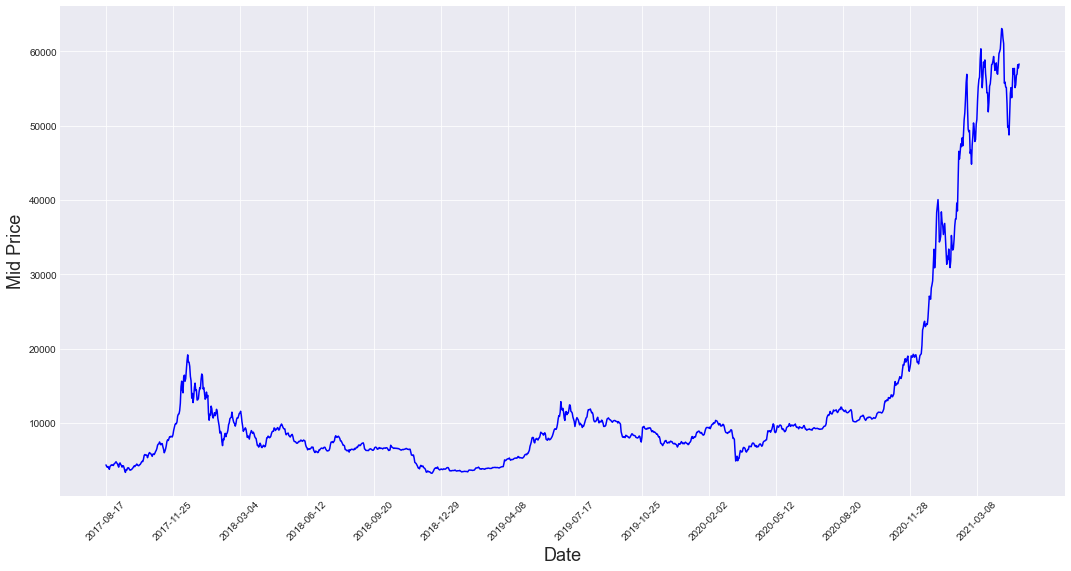

In [65]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['low']+df['high'])/2.0, color='b')
plt.xticks(range(0,df.shape[0],100),df['date'].loc[::100],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

We have all datapoints available in our dataset and our data is already sorted by date, so a cleaning of the data will not be nessesary. 

## Splitting the data into training and test sets
For this purpose we first calculate the index at which we need to split the data, followed by the splitting in the the train and test set. 

In [66]:
# Get the index 80% in the dataset
train_test_split_index = int(len(df['low'])*0.8)
train_test_split_index

1091

In [67]:
df = (df['low'] + df['high']) / 2

print(df.head())

df = np.array(df).reshape(-1,1)

scaler = MinMaxScaler()
df = scaler.fit_transform(df)

print(df)

# Split the data into 80% train and 20% test sets
x_train, x_test = df[:train_test_split_index], df[train_test_split_index:]

# Make sure they match up
x_train, x_test

# Fix the dateframe for the model
x_train, x_test = x_train.reshape(x_train.shape[0], 1), x_test.reshape(x_test.shape[0], 1)

def get_data(data, look_back):
  data_x, data_y = [],[]
  for i in range(len(data)-look_back-1):
    data_x.append(data[i:(i+look_back),0])
    data_y.append(data[i+look_back,0])
  return np.array(data_x) , np.array(data_y)

look_back = 1

x_train , y_train = get_data(x_train, look_back)

x_test , y_test = get_data(x_test,look_back)

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

1363    4343.065
1362    4155.145
1361    4017.345
1360    4121.850
1359    4015.705
dtype: float64
[[0.01882165]
 [0.01568238]
 [0.01338039]
 ...
 [0.91851973]
 [0.91130019]
 [0.92034479]]
(1089, 1)
(1089,)
(271, 1)
(271,)


In [68]:
# Fix the dateframe for the model
x_train, x_test = np.array(x_train), np.array(x_test)
x_train, x_test = x_train.reshape(x_train.shape[0],x_train.shape[1], 1), x_test.reshape(x_test.shape[0],x_test.shape[1], 1)
x_train.shape, x_test.shape

((1089, 1, 1), (271, 1, 1))

Now we have our training and test data we will use to train and test our model. 

# Building and training the model
We have decided to use a Long Short-Term Memory model as this makes it possible to predict longer in to the future when handling data in a time-series. 

## Setting up the parameters for the model

In [69]:
# Set up parameters for the model
n_features=1 # Defining number of datapoints per row


## Defining the model

In [70]:
#Defining the LSTM model
model=keras.models.Sequential()
model.add(keras.layers.LSTM(128,activation='relu',input_shape=(1,1)))
model.add(keras.layers.Dense(n_features))

#Model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [71]:
#Compiling
model.compile(optimizer='adam', loss = 'mse')

In [72]:
#Training
model.fit(x_train, y_train, epochs = 10, batch_size=1)

Epoch 1/10
1089/1089 [==============================] - 1s 564us/step - loss: 0.0017
Epoch 2/10
1089/1089 [==============================] - 1s 550us/step - loss: 3.8912e-05
Epoch 3/10
1089/1089 [==============================] - 1s 560us/step - loss: 3.7897e-05
Epoch 4/10
1089/1089 [==============================] - 1s 564us/step - loss: 4.1300e-05
Epoch 5/10
1089/1089 [==============================] - 1s 565us/step - loss: 4.2436e-05
Epoch 6/10
1089/1089 [==============================] - 1s 580us/step - loss: 5.3540e-05
Epoch 7/10
1089/1089 [==============================] - 1s 567us/step - loss: 4.1339e-05
Epoch 8/10
1089/1089 [==============================] - 1s 557us/step - loss: 3.8892e-05
Epoch 9/10
1089/1089 [==============================] - 1s 580us/step - loss: 4.3966e-05
Epoch 10/10
1089/1089 [==============================] - 1s 557us/step - loss: 3.9004e-05


In [73]:
#Prediction using the trained model
scaler.scale_

y_pred = model.predict(x_test)
y_pred = scaler.inverse_transform(y_pred)
print(y_pred[:10])

[[11472.322]
 [11322.973]
 [11474.018]
 [11689.005]
 [11778.982]
 [11757.36 ]
 [12074.64 ]
 [12058.215]
 [11738.624]
 [11725.801]]


In [74]:
#Processing test shape
y_test = np.array(y_test).reshape(-1,1)
y_test = scaler.inverse_transform(y_test)
print(y_test[:10])

[[11383.76 ]
 [11531.66 ]
 [11742.015]
 [11830.   ]
 [11808.86 ]
 [12118.89 ]
 [12102.85 ]
 [11790.54 ]
 [11778.   ]
 [11681.905]]


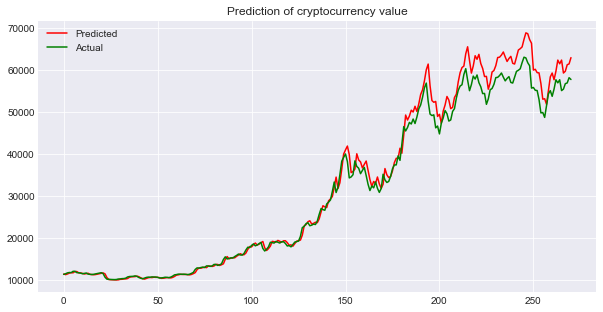

In [75]:
#Visualizing the results
plt.figure(figsize=(10,5))
plt.title('Prediction of cryptocurrency value')
plt.plot(y_pred , label = 'Predicted', color = 'r')
plt.plot(y_test , label = 'Actual', color = 'g')
plt.legend()

In [76]:
#Mean Squared Error
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_test[1], y_pred[1]))
print(y_test[1], y_pred[1])

loss = keras.losses.mean_squared_error(y_test, y_pred)
print(loss)

43550.407441429845
[11531.66] [11322.973]
tf.Tensor(
[7.84331641e+03 4.35504727e+04 7.18224297e+04 1.98796230e+04
 8.92690674e+02 1.30703430e+05 7.95801880e+02 7.16498047e+04
 1.55046753e+03 1.92681555e+03 9.24433398e+03 2.02611875e+04
 2.09381465e+04 4.34351992e+04 7.15544128e+01 7.59637573e+02
 1.26525146e+04 2.22015820e+04 2.20000742e+04 2.34987344e+04
 2.30476289e+04 3.01029277e+04 6.21807688e+05 1.49374703e+05
 6.71791748e+02 3.41243091e+03 3.02714893e+03 7.17677002e+03
 1.03181152e+04 3.93514766e+04 1.06385928e+04 2.43009727e+04
 9.26989062e+03 2.91298887e+04 1.33298438e+05 3.30334180e+04
 7.99400146e+03 1.00625977e+04 3.17205137e+04 4.08163770e+03
 3.56483164e+04 1.09349502e+04 2.26051953e+03 5.59544258e+04
 5.91002695e+04 2.22968477e+04 1.41747839e+03 2.73214434e+04
 1.31349609e+03 6.19925537e+03 3.17065773e+01 7.16486182e+03
 1.16726504e+04 1.80034023e+04 3.07146172e+04 8.82275635e+02
 6.93890259e+02 4.07527266e+04 9.00175781e+04 1.39204047e+05
 1.57188906e+04 3.05727266e+04 1

https://analyticsindiamag.com/foreign-exchange-rate-prediction-using-lstm-recurrent-neural-network/ 